**Exercise 7.1**

Let $k_{t}$ be the units of biomass at $t$, and $x = 1$ if harvested and $x = 0$ otherwise. Then,
$$
V(k_{t}) = \max \left\{p k_{t} - c + \delta V(1), \delta V(k_{t} + 1) \right\}
$$
where $k_{t} \in \mathbb{N}$

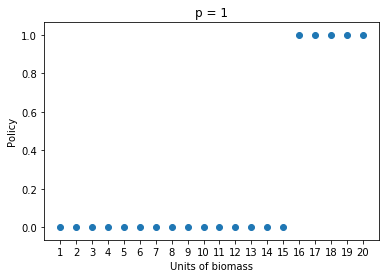

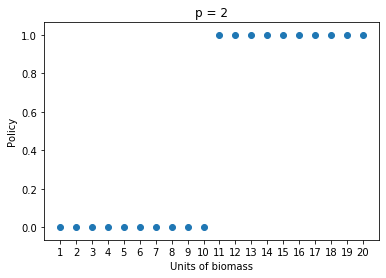

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


class TimberStand:

    def __init__(self, delta, p, c, k_max=20):
        self.delta, self.p, self.c, self.k_max = delta, p, c, k_max
        self.states = np.array([k + 1 for k in range(self.k_max)])
    
    def get_value(self, x, k, v_next):
        if x == 1 or k == self.k_max:
            return self.p * k - self.c + self.delta * v_next[0]
        return self.delta * v_next[k]

    def get_policy(self, k, v_next):
        if k == self.k_max:
            return 1
        v0 = self.get_value(0, k, v_next)
        v1 = self.get_value(1, k, v_next)
        return np.argmax([v0, v1])
    
    def get_max_value(self, k, v_next):
        x = self.get_policy(k, v_next)
        return self.get_value(x, k, v_next)
    
    def solve(self):
        v_next, d = np.zeros(self.k_max), 1000
        while d > 1.0e-8:
            v_old = v_next
            v_next = np.array([self.get_max_value(k, v_old) for k in self.states])
            d = np.linalg.norm(v_next - v_old)
        policy = np.array([self.get_policy(k, v_next) for k in self.states])
        return v_next, policy

delta, c = 0.95, 5
for p in [1, 2]:
    timber = TimberStand(delta, p, c)
    value, policy = timber.solve()
    plt.scatter(timber.states, policy)
    plt.xlabel('Units of biomass'), plt.ylabel('Policy')
    plt.xlim(0, 21), plt.xticks(timber.states)
    plt.title('p = {0:.0f}'.format(p))
    plt.show()


**Exercise 7.2**
Let $s = 1$ if firm operates in the previous period and $s = 0$ otherwise, and then
$$
V (s, \pi) = \max\left\{\pi + 1\{s = 0 \} c + \delta E[V (1, \pi)], \delta E[V (0, \pi)] \right\}
$$


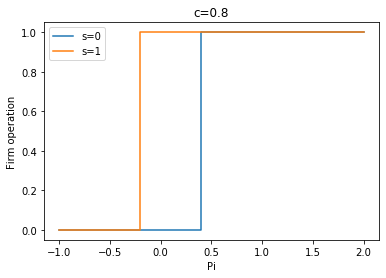

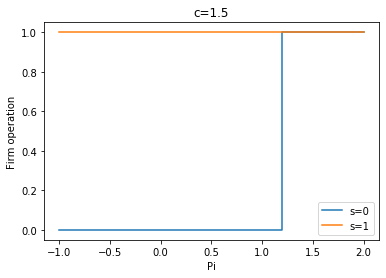

In [2]:
# Exercise 7.3 (a)
class FirmOperation:

    def __init__(self, delta, c, pis, trans_prob):
        self.delta, self.c, self.pis, self.trans_prob \
            = delta, c, pis, trans_prob
        self.npis = len(self.pis)

    def get_value(self, s, v_next):
        EV= np.dot(self.trans_prob, v_next)
        v = np.array([[0, pi + (s - 1) * c] for pi in self.pis])
        return np.max(v + self.delta * EV, axis=1)
    
    def get_max_value(self, v_next):
        v0 = self.get_value(0, v_next).reshape(self.npis, 1)
        v1 = self.get_value(1, v_next).reshape(self.npis, 1)
        return np.concatenate((v0, v1), axis=1)

    def get_policy(self, s, v_next):
        EV= np.dot(self.trans_prob, v_next)
        v = np.array([[0, pi + (s - 1) * c] for pi in self.pis])
        return np.argmax(v + self.delta * EV, axis=1)
    
    def solve(self):
        v_next, d = np.zeros((self.npis, 2)), 1000
        while d > 1.0e-8:
            v_old = v_next
            v_next = self.get_max_value(v_next)
            d = np.linalg.norm(v_next - v_old)
        policy = np.array([self.get_policy(s, v_next) for s in [0, 1]])
        return v_next, policy.T

delta, pis, = 0.95, np.array([-1.0, -0.2, 0.4, 1.2, 2.0])
trans_prob = np.array([
    [0.1, 0.2, 0.3, 0.4, 0.0],
    [0.1, 0.3, 0.2, 0.2, 0.2],
    [0.1, 0.5, 0.2, 0.1, 0.1],
    [0.2, 0.1, 0.3, 0.2, 0.2],
    [0.3, 0.2, 0.2, 0.1, 0.2]])

for c in [0.8, 1.5]:
    firm_operation = FirmOperation(delta, c, pis, trans_prob)
    value, policy = firm_operation.solve()

    fig, ax = plt.subplots()
    plt.xlabel('Pi'), plt.ylabel('Firm operation')
    for s, p in zip([0, 1], policy.T):
        ax.plot(firm_operation.pis, p, label='s={0:.0f}'.format(s),
            drawstyle='steps-post')
    ax.legend(loc=0)
    plt.title('c={0:.1f}'.format(c))
    plt.show()

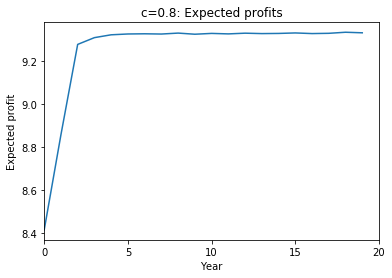

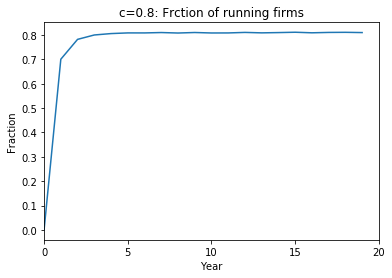

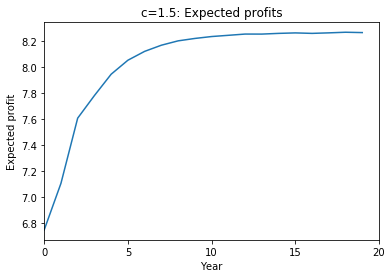

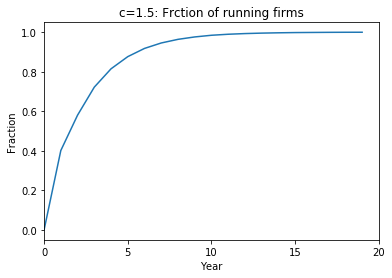

In [3]:
# Exercise 7.3 (b)
from quantecon import MarkovChain

nsim = 100000
pi = np.array([-1] * 10000)
T = 20

mc = MarkovChain(trans_prob, state_values=[i for i in range(len(pis))])
pi_idx = np.array([mc.simulate(ts_length=T, init=0) for i in range(nsim)])

for c in [0.8, 1.5]:
    firm_operation = FirmOperation(delta, c, pis, trans_prob)
    value, policy = firm_operation.solve()
    state, expected_profit = np.array([0] * nsim), []
    open_firms = []
    for t in range(T):
        values = np.array([value[pi_idx[i][t]][state[i]] for i in range(nsim)])
        expected_profit.append(values.mean())
        state = np.array([policy[pi_idx[i][t]][state[i]] for i in range(nsim)])
        open_firms.append(state.mean())

    ts = np.array([t for t in range(T)])
    plt.plot(ts, expected_profit)
    plt.xlabel('Year'), plt.ylabel('Expected profit')
    plt.xlim(0, T), plt.xticks([t for t in range(0, T + 5, 5)])
    plt.title('c={0:.1f}: Expected profits'.format(c))
    plt.show()

    plt.plot(ts, open_firms)
    plt.xlabel('Year'), plt.ylabel('Fraction')
    plt.xlim(0, T), plt.xticks([t for t in range(0, T + 5, 5)])
    plt.title('c={0:.1f}: Frction of running firms'.format(c))
    plt.show()

**Exercise 7.4**
Let $\bar{x}$ be the amount of initial stock and $P$ be transition probability matrix. Then,
$$
V(p_{t}, x_{t}) = \max_{a \in \{0, \dots, x_{t}\}} p a - 0.2 a^{1.5} + \delta E[V(p_{t+1}, \max(x_{t} - a, 0))]
$$

In [4]:
# Exercise 7.4 (b)
class Harvest:

    def __init__(self, delta, xbar, ps, P):
        self.delta, self.xbar, self.ps, self.P = delta, xbar, ps, P
        self.states_x = np.arange(0, xbar + 1)
        self.states_p = np.arange(1, len(ps) + 1)
        self.nstates_p, self.nstates_x = len(self.states_p), len(self.states_x)

    def get_reward(self, a, p):
        return p * a - 0.2 * a ** 1.5

    def get_value(self, a, x, p, v_next):
        p_idx = list(self.states_p).index(p)
        EV = np.dot(self.P[p_idx][:], v_next.T[x - a])
        return self.get_reward(a, p) + self.delta * EV

    def get_max_value_sub(self, x, p, v_next):
        return max([self.get_value(a, x, p, v_next) for a in range(x + 1)])

    def get_policy(self, x, p, v_next):
        return np.argmax([self.get_value(a, x, p, v_next) for a in range(x + 1)])

    def get_max_value(self, v_next):
        return np.array([[self.get_max_value_sub(x, p, v_next)
            for x in self.states_x] for p in self.states_p])
    
    def solve(self):
        v_next, d = np.zeros((self.nstates_p, self.nstates_x)), 1000
        while d > 1.0e-8:
            v_old = v_next
            v_next = self.get_max_value(v_next)
            d = np.linalg.norm(v_next - v_old)

        policy = np.array([[self.get_policy(x, p, v_next)
            for x in self.states_x] for p in self.states_p])
        return v_next, policy

delta, xbar, ps = 0.95, 100, np.array([1, 2])
P = np.array([[0.8, 0.2], [0.3, 0.7]])
harvest = Harvest(delta, xbar, ps, P)
value, policy = harvest.solve()

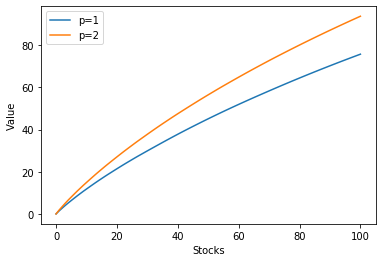

In [5]:
# Exercise 7.4 (b): continued
stocks = np.arange(0, len(value[0]))

fig, ax = plt.subplots()
ax.plot(stocks, value[0], label='p=1')
ax.plot(stocks, value[1], label='p=2')
plt.xlabel('Stocks'), plt.ylabel('Value')
ax.legend(loc=0)
plt.show()

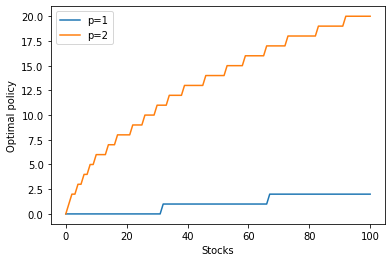

In [6]:
# Exercise (c)
fig, ax = plt.subplots()
ax.plot(stocks, policy[0], label='p=1')
ax.plot(stocks, policy[1], label='p=2')
plt.xlabel('Stocks'), plt.ylabel('Optimal policy')
ax.legend(loc=0)
plt.show()

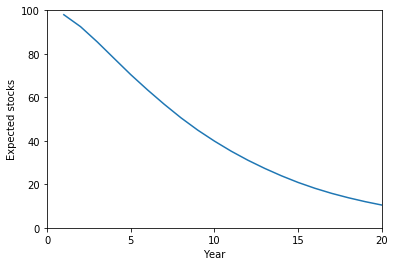

In [7]:
# Exercise 7.4 (d)
nsim, T = 10000, 20
p = np.array([1] * nsim)
mc = MarkovChain(harvest.P, state_values=[i for i in range(harvest.nstates_p)])
p_idx = np.array([mc.simulate(ts_length=T, init=0) for i in range(nsim)])

stocks = [harvest.xbar] * nsim
stocks_mean = []
for t in range(T):
    action = np.array([policy[p_idx[i][t]][stocks[i]] for i in range(nsim)])
    stocks = stocks - action
    stocks_mean.append(stocks.mean())

ts = [t + 1 for t in range(T)]
plt.plot(ts, stocks_mean)
plt.xlabel('Year'), plt.ylabel('Expected stocks')
plt.xlim(0, 20), plt.xticks([i for i in range(0, 25, 5)])
plt.ylim(0, 100), plt.yticks([i for i in range(0, 120, 20)])
plt.show()

**Exercise 7.5**
$$
V(q_{t-1}, s_{t}, d_{t}) = \max_{q \in \{0, 1, \dots, \bar{Q} \}} p d_{t} - C(q, q_{t-1}) - 2 \max\{s_{t} + q - d_{t}, 0\} + \delta E[V(q, s_{t} + q - d_{t}, d')] 
$$

In [8]:
# Exercise 7.5 (b)
import quantecon as qe
from numba import jit, jitclass, f8, i8


class Production:

    def __init__(self, delta, price, stock_cost, states_d, prob, Qbar, Sbar):
        self.delta, self.price, self.stock_cost, self.states_d, self.prob, self.Qbar, self.Sbar \
            = delta, price, stock_cost, states_d, prob, Qbar, Sbar
        self.nstates_d = len(self.states_d)
        self.states_q = np.arange(0, self.Qbar + 1)
        self.nstates_q = len(self.states_q)
        self.states_s = np.arange(0, self.Sbar + 1)
        self.nstates_s = len(self.states_s)
        self.states = qe.cartesian((self.states_d, self.states_q, self.states_s))
        self.nstates = len(self.states)
        self.state_dict = {tuple(state): i for i, state in enumerate(self.states)}

    def cost_func(self, q1, q0):
        return 10 * q1 + (q1 - q0) ** 2

    def reward (self, d, q1, q0, s):
        return self.price * d - self.cost_func(q1, q0) - self.stock_cost * max(s + q1 - d, 0)

    def get_index(self, d, q, s):
        return self.state_dict[(d, q, s)]

    def get_EV(self, q, s, v):
        v_next = np.array([v[self.get_index(d, q, s)] for d in self.states_d])
        return np.dot(self.prob, v_next)

    def get_value(self, d, q1, q0, s, v):
        if q1 + s < d or q1 + s - d > self.Sbar:
            return -np.inf
        return self.reward(d, q1, q0, s) + self.delta * self.get_EV(q1, s + q1 - d, v)

    def get_max_value(self, d, q0, s, v):
        return np.max([self.get_value(d, q, q0, s, v) for q in self.states_q])

    def get_policy(self, d, q0, s, v):
        return np.argmax([self.get_value(d, q, q0, s, v) for q in self.states_q])

    def solve(self):
        v_new, v_old = np.zeros(self.nstates), np.ones(self.nstates)
        while np.linalg.norm(v_new - v_old) > 1.0e-8:
            v_old = v_new
            v_new = np.array([self.get_max_value(*state, v_new) for state in self.states])
        policy = [self.get_policy(*state, v_new) for state in self.states]
        return v_new, policy


states_d = np.arange(5, 9)
prob = np.array([0.1, 0.3, 0.4, 0.2])
nstates_d = len(states_d)
delta, price, stock_cost, Qbar, Sbar = 0.9, 20, 2, 8, 5

pd = Production(delta, price, stock_cost, states_d, prob, Qbar, Sbar)
value, policy = pd.solve()

print(policy[pd.get_index(7, 5, 2)])

5


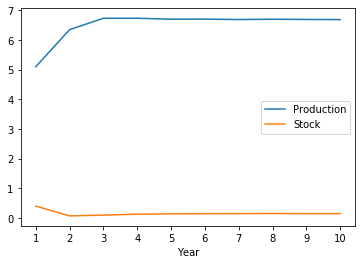

In [9]:
# Exercise 7.5 (c)
def generate_demand(states_d, prob):
    u, cum = np.random.rand(1), 0
    for d, prob in zip(states_d, prob):
        cum = cum + prob
        if u <= cum:
            return d

nsim, T = 10000, 10
s, q = [2] * nsim, [5] * nsim
s_mean, q_mean = [], []
for t in range(T):
    d = np.array([generate_demand(pd.states_d, pd.prob) for i in range(nsim)])
    q = np.array([policy[pd.get_index(d[i], q[i], s[i])] for i in range(nsim)])
    s = s + q - d
    
    q_mean.append(q.mean())
    s_mean.append(s.mean())

ts = np.arange(1, T + 1)
fig, ax = plt.subplots()
ax.plot(ts, q_mean, label='Production')
ax.plot(ts, s_mean, label='Stock')
plt.xlabel('Year'), plt.xticks(np.arange(1, T + 1))
plt.legend(loc=0)
plt.show()

**Exercise 7.6**
Let k be the number of lactation (by the previous period). Then,
$$
\begin{aligned}
&V(k) = \max \left\{ p y(k + 1) + \delta V(k + 1), p y(1) - c + \delta V(1) \right\} \qquad (k = 1, \dots, 9) \\
&V(10) = p y(1) - c + \delta V(2) \\
\end{aligned}
$$


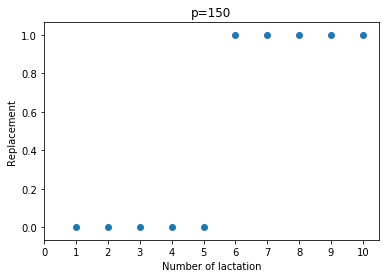

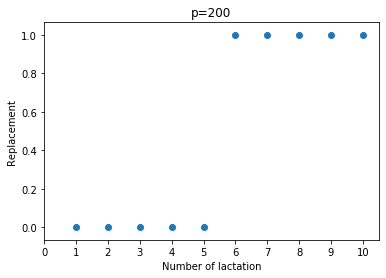

In [10]:
# Exercise 7.6 (b)
class Lactation:

    def __init__(self, delta, price, c, P):
        self.delta, self.price, self.states_c, self.P = delta, price, c, P
        self.states_k = np.arange(1, 11)
        self.nstates_k, self.nstates_c = len(self.states_k), len(self.states_c)

    def milk_yield(self, k):
        return self.price * (8 + 2 * k - 0.25 * k ** 2)

    def get_EV(self, k, c, v):
        cidx = list(self.states_c).index(c)
        return np.dot(self.P[cidx], v.T[k - 1])
    
    def get_value(self, a, k, c, v_next):
        if a == 1 or k == 10:
            return self.milk_yield(1) - c + self.delta * self.get_EV(1, c, v_next)
        return self.milk_yield(k + 1) + self.delta * self.get_EV(k + 1, c, v_next)

    def get_max_value_sub(self, k, c, v_next):
        return max(self.get_value(0, k, c, v_next), self.get_value(1, k, c, v_next))

    def get_policy(self, k, c, v_next):
        if k == 10:
            return 1
        return np.argmax([self.get_value(0, k, c, v_next), self.get_value(1, k, c, v_next)])

    def get_max_value(self, v_next):
        return np.array([[self.get_max_value_sub(k, c, v_next)
            for k in self.states_k] for c in self.states_c])

    def solve(self):
        v_next, d = np.zeros((self.nstates_c, self.nstates_k)), 1000
        while d > 1.0e-8:
            v_old = v_next
            v_next = self.get_max_value(v_next)
            d = np.linalg.norm(v_next - v_old)

        policy = np.array([[self.get_policy(k, c, v_next)
            for k in self.states_k] for c in self.states_c])
        return v_next, policy


for p in [150, 200]:
    delta, c, P = 0.9, np.array([500]), np.array([[1]])
    lactation = Lactation(delta, p, c, P)
    value, policy = lactation.solve()

    ks = lactation.states_k
    plt.scatter(ks, policy[0])
    plt.xlabel('Number of lactation'), plt.ylabel('Replacement')
    plt.xlim(0, 10.5), plt.xticks([k for k in range(11)])
    plt.title('p={0:.0f}'.format(p))
    plt.show()

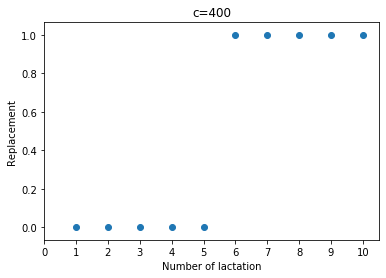

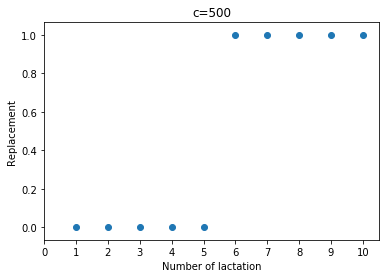

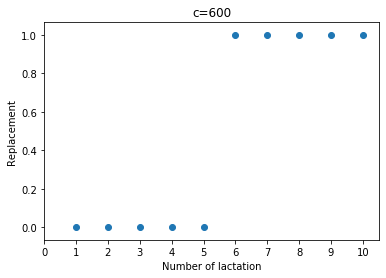

In [11]:
# Exercise 7.6 (c)
p = 150
c = np.array([400, 500, 600])
P = np.array([[0.5, 0.4, 0.1], [0.2, 0.6, 0.2], [0.1, 0.4, 0.5]])
lactation_c = Lactation(delta, p, c, P)
value, policy = lactation_c.solve()

for c_idx, c in enumerate(lactation_c.states_c):
    plt.scatter(lactation_c.states_k, policy[c_idx])
    plt.xlabel('Number of lactation'), plt.ylabel('Replacement')
    plt.xlim(0, 10.5), plt.xticks([k for k in range(11)])
    plt.title('c={0:.0f}'.format(c))
    plt.show()